# Day 9: A Brief Look at Data Analysis

---

PDO is not a class on data, but being able to work with data is a fundamental part of model analysis.



In [15]:
# Implements the DataFrame class; a dependency for Grama
import pandas as pd
# Implements the Model class; also has tools for DataFrames
import grama as gr
# Really slick plotting package
import plotnine as pt

# We'll talk about this soon....
DF = gr.Intention()

# Data pipelines

---


Let's take another look at the trajectory data from a few classes ago:

In [35]:
from grama.data import df_trajectory_full
df_trajectory_full.head()

,t,x,y
0,0.0,0.5,0.1
1,0.1,2.1,3.0
2,0.2,4.0,5.5
3,0.3,5.5,8.1
4,0.4,7.1,10.3


Remember we talked about estimating parameter bounds for fitting a model? We could do that with some crude estimates:


In [36]:
dx = df_trajectory_full.x[1] - df_trajectory_full.x[0] 
dt = df_trajectory_full.t[1] - df_trajectory_full.t[0] 

u_est = dx / dt
u_est


16.0

But maybe we should try this for multiple values; could write a for loop:


In [39]:
for i in range(df_trajectory_full.shape[0]):
    dx = df_trajectory_full.x[i+1] - df_trajectory_full.x[i] 
    dt = df_trajectory_full.t[i+1] - df_trajectory_full.t[i] 
    
    u_est = dx / dt
    print(u_est)
    

16.0
18.999999999999996
15.000000000000004
15.999999999999991
22.000000000000014
15.000000000000004
13.99999999999999
16.999999999999996
19.000000000000007
10.000000000000002
8.999999999999979
16.000000000000036
11.999999999999982
13.000000000000025
9.999999999999991
8.0
8.999999999999998
11.000000000000004
8.999999999999998
6.000000000000009
6.999999999999987
10.99999999999997
5.000000000000018
11.000000000000004
0.0
8.0
5.999999999999973
3.0000000000000533
4.999999999999996
7.9999999999999645
2.999999999999969
7.000000000000022
4.0
3.00000000000004
6.999999999999951
1.0000000000000133
9.999999999999991
4.0


KeyError: 39

Gah, but I have to look out for the last index... and I have to store intermediate values...

*Isn't there a better way?!?!*


In [54]:
(
    df_trajectory_full
    >> gr.tf_mutate(
        u=(gr.lead(DF.x) - DF.x) / (gr.lead(DF.t) - DF.t),
        v=(gr.lead(DF.y) - DF.y) / (gr.lead(DF.t) - DF.t),
    )
    >> gr.tf_select("u", "v")
    >> gr.tf_describe()
)

,u,v
count,38.000000,38.000000
mean,9.710526,0.710526
std,5.367106,15.388497
min,0.000000,-33.000000
25%,6.000000,-8.500000
50%,9.000000,0.500000
75%,13.750000,11.500000
max,22.000000,29.000000


## Some useful concepts

- Pipe-enabled Grama functions
- The data pronoun
- Useful verbs


In [55]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

### The Pipe `>>`

The pipe operator `>>` is a special feature of Grama. For comparison, let's look at a some Grama code:


Calling plot_hists....


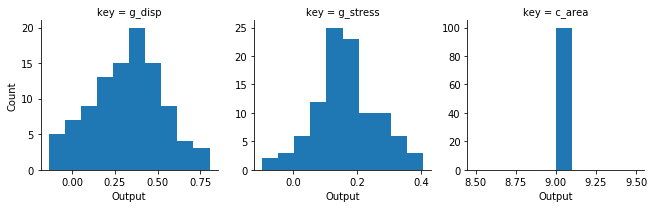

In [56]:
df_mc = gr.eval_monte_carlo(md_beam, df_det="nom", n=100)
gr.plot_auto(df_mc)

We can also call this using *pipe-enabled verbs*


Calling plot_hists....


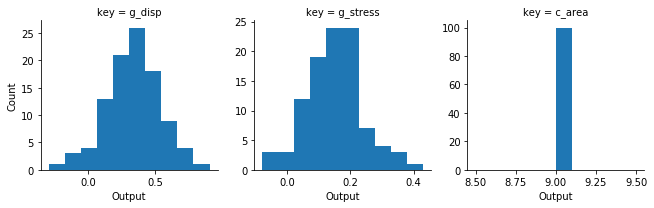

In [57]:
## Non-pipe verbs
# df_mc = gr.eval_monte_carlo(md_beam, df_det="nom", n=100)
# gr.plot_auto(df_mc)

## Pipe-enabled version
(
    md_beam
    >> gr.ev_monte_carlo(df_det="nom", n=100) # md -> df
    >> gr.pt_auto()
)

This is helpful for many reasons:

- We can focus on inputs and outputs; the input to `monte_carlo` is more prominent in the pipe-enabled version
- We can eliminate the intermediate variable `df_mc`; this gives us one less variable to track
- We can easily add or remove verbs from a pipeline


## The Data Pronoun

The function `gr.Intention()` allows us to create a "data pronoun":


In [ ]:
DF = gr.Intention()


This is helpful when we are carrying out a long chain of operations in a pipeline, and want to access *intermediate* steps:


In [65]:
## Pipe-enabled code
# (
#     df_trajectory_full
#     >> gr.tf_mutate(
#         u=(gr.lead(DF.x) - DF.x) / (gr.lead(DF.t) - DF.t),
#         v=(gr.lead(DF.y) - DF.y) / (gr.lead(DF.t) - DF.t),
#     )
#     >> gr.tf_select("u", "v")
#     >> gr.tf_describe()
# )

## Non-pipe version
df_tmp = df_trajectory_full
df_tmp["u"] = (gr.lead(df_tmp.x) - df_tmp.x) / (gr.lead(df_tmp.t) - df_tmp.t)
df_tmp["v"] = (gr.lead(df_tmp.y) - df_tmp.y) / (gr.lead(df_tmp.t) - df_tmp.t)
df_tmp[["u", "v"]].describe()


,u,v
count,38.000000,38.000000
mean,9.710526,0.710526
std,5.367106,15.388497
min,0.000000,-33.000000
25%,6.000000,-8.500000
50%,9.000000,0.500000
75%,13.750000,11.500000
max,22.000000,29.000000


## Useful verbs

`gr.tf_mutate()` allows you to modify or add columns.
- [this page](https://github.com/zdelrosario/py_grama/blob/master/grama/mutate_helpers.py) has some useful mutate helpers


In [73]:
(
    df_trajectory_full
    >> gr.tf_mutate(
        ## Distance from origin
        d=gr.sqrt(DF.x**2 + DF.y**2),
        ## Approximate path length
        s=gr.cumsum(gr.sqrt((gr.lead(DF.x)-DF.x)**2 + (gr.lead(DF.y)-DF.y)**2))
    )
    >> gr.tf_head()
)

,t,x,y,u,v,d,s
0,0.0,0.5,0.1,16.0,29.0,0.509902,3.312099
1,0.1,2.1,3.0,19.0,25.0,3.661967,6.452163
2,0.2,4.0,5.5,15.0,26.0,6.800735,9.453829
3,0.3,5.5,8.1,16.0,22.0,9.790812,12.174123
4,0.4,7.1,10.3,22.0,18.0,12.509996,15.016657


`gr.tf_filter()` allows you to keep only those observations that satisfy some constraint
- [this page](https://github.com/zdelrosario/py_grama/blob/master/grama/dfply/mask_helpers.py) has some useful filter helpers


In [71]:
## Approximate apex
(
    df_trajectory_full
    >> gr.tf_filter(DF.y == gr.colmax(DF.y))
)

,t,x,y,u,v
0,1.9,26.5,25.2,6.0,-3.0


# Worked Example: Aircraft Data

---

I'm going to work through an example of tidying and visualizing a dataset. Remember that this is up in the notes repository, so you can go through it yourself!


In [2]:
filename_aircraft = "./data/wing_weight.csv"
df_aircraft = pd.read_csv(filename_aircraft)

In [3]:
df_aircraft.head()


,Group,Name,Symbol,Units,Citation 500 Series,MDAT 30,MDAT 50,F-28,MDAT 70,DC-9-10,...,DC-10-40,747,SCAT-15,C-130A,C130E,KC-135A,C-133B,C-141A,C-5A,AST
0,wing,wing_system_weight,W_1,lbs,1020.0,3143.0,4360.0,7526.0,5910.0,9366.0,...,57748.0,88741.0,83940.0,10593.0,11647.0,24719.0,27064.0,34262.0,81782.0,20560.0
1,wing,takeoff_gross,TOGW,lbs,11500.0,34480.0,46850.0,62000.0,61000.0,86300.0,...,565000.0,775000.0,631000.0,108000.0,155000.0,275000.0,286000.0,316100.0,728000.0,163500.0
2,wing,zero_fuel_weight,ZFW,lbs,8900.0,27450.0,37760.0,47600.0,49460.0,71800.0,...,391000.0,526500.0,364550.0,87290.0,107890.0,190380.0,215000.0,204500.0,542800.0,143000.0
3,wing,trap_area,S_W,sq_ft,269.0,342.0,464.0,822.0,605.0,934.0,...,3610.0,4960.0,10744.0,1808.0,1808.0,2453.0,2673.0,3000.0,6200.0,1890.0
4,wing,wing_loading,W/S,lb/sq_ft,43.0,101.0,101.0,75.0,101.0,92.0,...,157.0,156.0,59.0,60.0,86.0,112.0,107.0,105.0,117.0,87.0


In [5]:
df_aircraft.columns

Index(['Group', 'Name', 'Symbol', 'Units', 'Citation 500 Series', 'MDAT 30',
       'MDAT 50', 'F-28', 'MDAT 70', 'DC-9-10', 'BAC-111', 'DC-9-30',
       '737-200', '727-100', '727-200', '707-320', 'DC-8-55', 'DC-8-62',
       'DC-10-10', 'L-1011', 'DC-10-40', '747', 'SCAT-15', 'C-130A', 'C130E',
       'KC-135A', 'C-133B', 'C-141A', 'C-5A', 'AST'],
      dtype='object')

In [75]:
(
    df_aircraft
    >> gr.tf_gather("aircraft", "value", aircraft)
)

,Group,Name,Symbol,Units,aircraft,value
0,wing,wing_system_weight,W_1,lbs,Citation 500 Series,1020.0
1,wing,takeoff_gross,TOGW,lbs,Citation 500 Series,11500.0
2,wing,zero_fuel_weight,ZFW,lbs,Citation 500 Series,8900.0
3,wing,trap_area,S_W,sq_ft,Citation 500 Series,269.0
4,wing,wing_loading,W/S,lb/sq_ft,Citation 500 Series,43.0
...,...,...,...,...,...,...
463,tail,vert_plus_rudder,W_2B,lbs,AST,2602.0
464,tail,horiz_area,S_h,sq_ft,AST,730.0
465,tail,vert_area,S_v,sq_ft,AST,648.0
466,body,body_weight,W_3,lbs,AST,29025.0


In [10]:
aircraft = df_aircraft.columns.drop(["Group", "Name", "Symbol", "Units"])
aircraft

Index(['Citation 500 Series', 'MDAT 30', 'MDAT 50', 'F-28', 'MDAT 70',
       'DC-9-10', 'BAC-111', 'DC-9-30', '737-200', '727-100', '727-200',
       '707-320', 'DC-8-55', 'DC-8-62', 'DC-10-10', 'L-1011', 'DC-10-40',
       '747', 'SCAT-15', 'C-130A', 'C130E', 'KC-135A', 'C-133B', 'C-141A',
       'C-5A', 'AST'],
      dtype='object')

In [24]:
df_aircraft_tidy = (
    df_aircraft
    >> gr.tf_gather("aircraft", "value", aircraft)
    >> gr.tf_select("Symbol", "aircraft", "value")
    >> gr.tf_spread("Symbol", "value")
)
df_aircraft_tidy

,aircraft,AR,I_W,N_p,Omega C/4,S_W,S_h,S_v,TOGW,U,W/S,W_1,W_2,W_2A,W_2B,W_3,ZFW,lambda,t/c
0,707-320,7.30,14055.0,162.0,35.0,2892.0,625.0,312.0,312000.0,3.75,108.0,28647.0,6004.0,4043.0,1961.0,22299.0,190000.0,0.300,0.120
1,727-100,7.70,6192.0,138.0,32.0,1520.0,377.0,384.0,161000.0,3.75,106.0,17682.0,4148.0,1999.0,2149.0,17589.0,118000.0,0.372,0.123
2,727-200,7.70,7018.0,158.0,32.0,1520.0,377.0,384.0,175000.0,3.75,115.0,18529.0,4142.0,1921.0,2221.0,22415.0,140000.0,0.372,0.123
3,737-200,7.80,2740.0,115.0,25.0,964.0,312.0,224.0,104000.0,3.75,108.0,11164.0,2777.0,1606.0,1171.0,11920.0,85000.0,0.340,0.133
4,747,7.70,59172.0,435.0,37.5,4960.0,1470.0,830.0,775000.0,3.75,156.0,88741.0,11958.0,8017.0,3941.0,68452.0,526500.0,0.356,0.122
5,AST,7.00,6583.0,4563.0,25.0,1890.0,730.0,648.0,163500.0,5.10,87.0,20560.0,8730.0,5127.0,2602.0,29025.0,143000.0,0.300,0.100
6,BAC-111,8.60,3512.0,99.0,22.2,1014.0,258.0,180.0,99650.0,3.75,98.0,9817.0,2470.0,1610.0,860.0,11274.0,81000.0,0.333,0.112
7,C-130A,9.70,5007.0,3339.0,0.0,1808.0,545.0,300.0,108000.0,4.50,60.0,10593.0,3190.0,2106.0,1084.0,14045.0,87290.0,0.440,0.147
8,C-133B,12.10,14703.0,6900.0,0.0,2673.0,801.0,537.0,286000.0,3.75,107.0,27064.0,6147.0,3721.0,2426.0,32119.0,215000.0,0.226,0.163
9,C-141A,8.50,16232.0,5096.0,25.0,3000.0,483.0,416.0,316100.0,3.75,105.0,34262.0,5745.0,3155.0,2590.0,28578.0,204500.0,0.335,0.121


Now that the data are tidy, we can run all kinds of analyses:


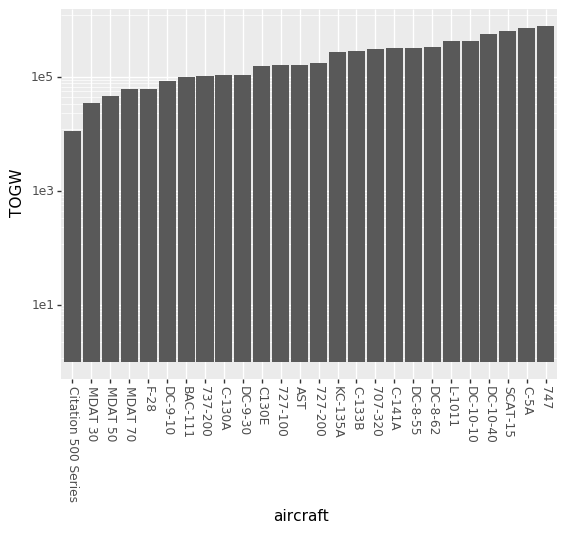

<ggplot: (8767544958561)>

In [27]:
(
    df_aircraft_tidy
    >> gr.tf_mutate(aircraft=gr.fct_reorder(DF.aircraft, DF.TOGW))
    
    >> pt.ggplot(pt.aes("aircraft", "TOGW"))
    + pt.geom_col()
    + pt.scale_y_log10()
    + pt.theme(axis_text_x=pt.element_text(angle=270))
)

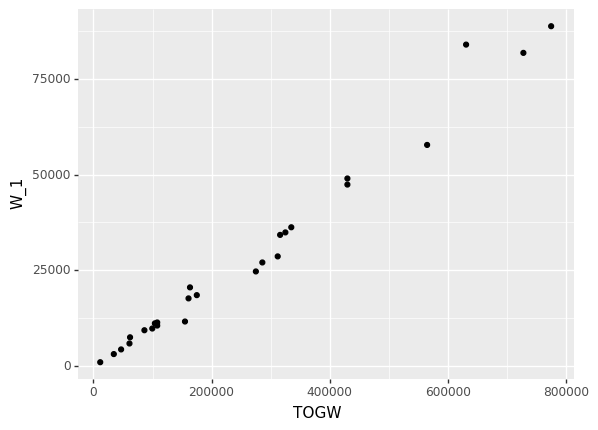

<ggplot: (8767544973853)>

In [31]:
# df_aircraft_tidy.columns
(
    df_aircraft_tidy
    >> pt.ggplot(pt.aes("TOGW", "W_1"))
    + pt.geom_point()
)

## Aside: Plotly is Amazing

If you have some extra time on your hands, I *highly* recommend learning the [Plotly](https://plotly.com/python/plotly-express/) library for Python. It's extremely useful for interactive data exploration.


In [58]:
import plotly.express as px


One of the *most important features* of plotly is that plots are interactive, and you can assign variables to be shown on mouse hover:


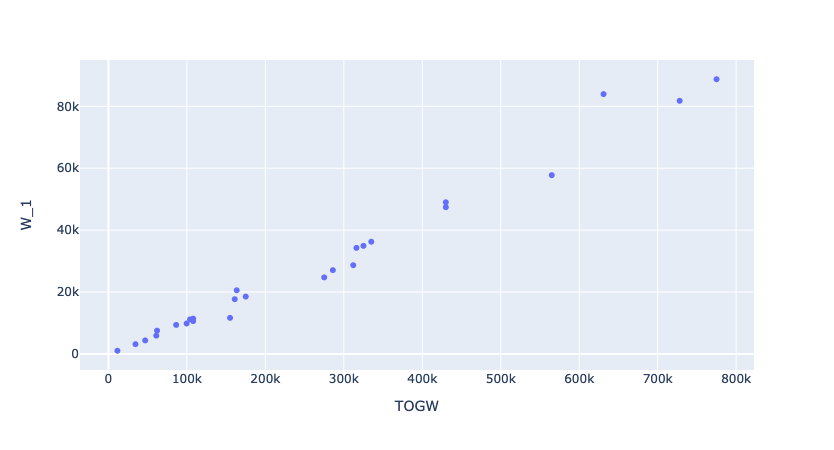

In [61]:
px.scatter(df_aircraft_tidy, x="TOGW", y="W_1", hover_data=["aircraft"])

## What questions can we answer with this dataset?

- Which is the heaviest aircraft?
- Which is the lightest aircraft?
- What's a typical sweep angle `Omega C/4`?
- 
